In [47]:
import sqlite3
import random
from shapely.geometry import Polygon
from shapely.wkt import dumps
import numpy as np
from shapely.affinity import translate


from shapely.affinity import scale


In [2]:
from tqdm import tqdm

In [3]:
# Connect to the SQLite database
conn = sqlite3.connect('/opt/sl/spatialite.db')
conn.enable_load_extension(True)
conn.load_extension('mod_spatialite')
cursor = conn.cursor()

# Initialize SpatiaLite metadata
cursor.execute("SELECT InitSpatialMetaData();")

In [4]:
# Create a table to store the polygons
cursor.execute("""
CREATE TABLE IF NOT EXISTS polygons (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    geom GEOMETRY
);
""")
cursor.execute("SELECT AddGeometryColumn('polygons', 'geom', 4326, 'POLYGON', 'XY');")

AddGeometryColumn: "duplicate column name: geom"


In [5]:
def generate_random_polygon(max_area=10):
    num_points = random.randint(10, 20)  # Polygons need at least 3 points

    # Generate points in polar coordinates
    radii = np.sqrt(np.random.uniform(0, 1, num_points))  # Square root ensures uniform distribution
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)

    # Convert polar coordinates to Cartesian coordinates
    points = [(r * np.cos(a), r * np.sin(a)) for r, a in zip(radii, angles)]

    # Sort points to form a simple polygon
    sorted_points = sorted(points, key=lambda p: np.arctan2(p[1], p[0]))

    # Create a Polygon and scale its area
    polygon = Polygon(sorted_points)

    # Calculate scaling factor
    current_area = polygon.area
    if current_area > 0:
        scaling_factor = np.sqrt(max_area / current_area)
        scaled_points = [(x * scaling_factor, y * scaling_factor) for x, y in sorted_points]
        polygon = Polygon(scaled_points)


    translation_x = random.uniform(0, 50)
    translation_y = random.uniform(0, 50)
    polygon = translate(polygon, xoff=translation_x, yoff=translation_y)

    return polygon
    

9.999999999999988


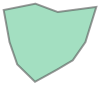

In [6]:
p=generate_random_polygon(10)
print(p.area)
p

In [44]:
%%time
# Insert 10,000 random polygons in batches of 5,000
batch_size = 10_000
polygons = []

for _ in tqdm(range(100_000)):
    polygon = generate_random_polygon()
    wkt = dumps(polygon)
    polygons.append((wkt,))
    
    if len(polygons) == batch_size:
        cursor.executemany("INSERT INTO polygons (geom) VALUES (GeomFromText(?, 4326));", polygons)
        polygons = []

# Insert any remaining polygons
if polygons:
    cursor.executemany("INSERT INTO polygons (geom) VALUES (GeomFromText(?, 4326));", polygons)

# Commit changes and close the connection
conn.commit()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:37<00:00, 2678.15it/s]

CPU times: user 37.9 s, sys: 752 ms, total: 38.7 s
Wall time: 37.4 s


In [25]:
cursor = conn.cursor()

# Query 10 random polygons
cursor.execute("SELECT id, geom FROM polygons ORDER BY RANDOM() LIMIT 10;")
rows = cursor.fetchall()

# Print out the results and confirm that geometry is stored as a BLOB
for row in rows:
    polygon_id, geom = row
    print(f"ID: {polygon_id}, Geometry (BLOB): {geom}")

# Close the connection


ID: 60520, Geometry (BLOB): b'\x00\x01\xe6\x10\x00\x00\x14\\\x90O\x8e\xcd\xf5?\x11)\xc6\xb7`\xc9\x14@\xcc\xa9!\x9c\x84\x92\x15@\xde\x04e*O"$@|\x03\x00\x00\x00\x01\x00\x00\x00\x10\x00\x00\x00\xe2s\x9a\x86\xe7)\xf6?cPg\xb2\xbe \x1d@\xf0H\x13X|\x06\xf7?t\xca\xc19\x8a\xb6\x19@3\xf3D\\k6\x01@M\x92\xf2\x15\x17\xe1\x17@\xabcB\xd4+\xea\x06@\x11)\xc6\xb7`\xc9\x14@\x05\xe3\xb6i\xd4\xee\n@\xde:3=\xf1\x98\x1b@\rtt\x11t\x17\x0e@\x08K\xeb\xb3\xfa\xc3\x1b@\x8fA\xb0\x9a$ \x11@\x817\xb7>g\x8a\x1c@\xcc\xa9!\x9c\x84\x92\x15@R\xe3\xdaW\xd6\x9a\x1e@\xd9\xdb\xf6b0\\\x12@7\xa5\x16\xf4\xfd\x9b @\x9c\x98@`{E\x10@\xc9X\x7f\xef\x13g!@\xf8;\x03\x08\x15B\x0f@\xde\x04e*O"$@\x9a\xff\x92lB\t\x07@w,\xaf\xbd3\xec#@<\x95\x95\x1f\x9b\x19\x02@\x9cU\\\xe2\xeaG"@\x14\\\x90O\x8e\xcd\xf5?\xc2\x08\r\xa6\xfc\xdb!@?x\xa5\xe5$g\xf7?\x14\x10\xbc0\t\x02 @\xe2s\x9a\x86\xe7)\xf6?cPg\xb2\xbe \x1d@\xfe'
ID: 98536, Geometry (BLOB): b'\x00\x01\xe6\x10\x00\x00\xf8\xdbg1\xe3\x01!@ \x88E\x02!\xdd @]\x1d=\x9b\x04\xcb*@\xc7\x83)1\x84\x92)@|\x

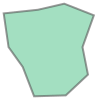

In [46]:
search_polygon.sc

In [70]:
%%timeit
search_polygon = generate_random_polygon()


scale_factor=3
search_polygon=scale(search_polygon,xfact=scale_factor,yfact=scale_factor,origin="centroid")
search_polygon
print(search_polygon.area)

search_wkt = dumps(search_polygon)

# Query for intersections with the new polygon
# cursor.execute("""
# SELECT id, AsText(ST_Envelope(geom)) AS bbox
# FROM polygons
# WHERE ST_Intersects(geom, GeomFromText(?, 4326));
# """, (search_wkt,))



#----------
#----------


# #--- get the whole thing as geojson
# cursor.execute("""
# SELECT id, AsGeoJSON((geom)) AS bbox
# FROM polygons
# WHERE ST_Intersects((geom), ST_Envelope(GeomFromText(?, 4326)));
# """, (search_wkt,))

# #--- get the whole thing as geojson
# cursor.execute("""
# SELECT id, AsGeoJSON((geom)) AS bbox
# FROM polygons
# WHERE ST_Intersects(ST_Envelope(geom), ST_Envelope(GeomFromText(?, 4326)));
# """, (search_wkt,))

#--- get the whole thing as geojson
cursor.execute("""
SELECT id, AsGeoJSON((geom)) AS bbox
FROM polygons
WHERE ST_Intersects(geom, GeomFromText(?, 4326));
""", (search_wkt,))


# #--- getthe centroid as geojson
# cursor.execute("""
# SELECT id, AsGeoJSON(ST_Centroid(geom)) AS bbox
# FROM polygons
# WHERE ST_Intersects(geom, GeomFromText(?, 4326));
# """, (search_wkt,))

# #--- ID only as baesline
# cursor.execute("""
# SELECT id 
# FROM polygons
# WHERE ST_Intersects(geom, GeomFromText(?, 4326));
# """, (search_wkt,))


#--------- only count
# cursor.execute("""
# SELECT count(*)
# FROM polygons
# WHERE ST_Intersects(geom, GeomFromText(?, 4326));
# """, (search_wkt,))


#----------
#----------

# # Print the bounding box of the query polygon
# search_bbox = search_polygon.bounds
# print(f"Query Polygon Bounding Box: {search_bbox}")


# Print the resulting IDs and bounding boxes
rows = cursor.fetchall()
print(f"{len(rows)=}")
# for row in rows:
#     polygon_id, bbox = row
#     print(f"ID: {polygon_id}, Bounding Box: {bbox}")

89.99999999999991
len(rows)=8216
90.0
len(rows)=17865
90.00000000000013
len(rows)=16898
90.00000000000003
len(rows)=9980
90.00000000000007
len(rows)=14723
89.99999999999996
len(rows)=15730
89.99999999999999
len(rows)=10473
90.00000000000006
len(rows)=17844
455 ms ± 71.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
%%timeit

search_polygon = generate_random_polygon()

scale_factor=3
search_polygon=scale(search_polygon,xfact=scale_factor,yfact=scale_factor,origin="centroid")

# search_polygon
# print(search_polygon.area)

search_wkt = dumps(search_polygon)


cursor.execute("""
with FilteredData AS (
    SELECT id, geom
    FROM polygons
    WHERE ST_Intersects(geom, GeomFromText(?, 4326))
),
RowCount AS (
    SELECT COUNT(*) AS cnt FROM FilteredData
)

-- Conditionally select columns based on the row count
SELECT 
    id,
    CASE 
        WHEN cnt < 20000 THEN AsGeoJSON(geom)
        ELSE AsGeoJSON(ST_Centroid(geom))
    END AS result
FROM FilteredData, RowCount
""", (search_wkt,))

# Print the resulting IDs and bounding boxes
rows = cursor.fetchall()
print(f"{len(rows)=}")

# for row in rows:
#     polygon_id, bbox = row
#     print(f"ID: {polygon_id}, Bounding Box: {bbox}")


len(rows)=10633
len(rows)=15642
len(rows)=17300
len(rows)=17183
len(rows)=13951
len(rows)=17385
len(rows)=11955
len(rows)=9968
669 ms ± 100 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
